# ML Project: Reddit Activity and Performance of Stock Prices

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from analysis_auxiliary import (
    add_word_counter,
    analyze_sentiment,
    create_date_cols_reddit_data,
    create_date_cols_stock_data,
    merge_reddit_and_stock_data,
    plot,
)

# Prepare Data

In [2]:
# Load data
gme = pd.read_csv("data/GME_hourly_september.csv")
wsb = pd.read_csv("data/wsb_sep_01_feb_26.csv")

gme = create_date_cols_stock_data(gme, "date")
wsb = create_date_cols_reddit_data(wsb, "date")

wsb_GME = add_word_counter(
    wsb, text_col="title", buzz_words=["GME", "Gamestop"], counter_col="GME_counts"
)

In [3]:
# Sentiment Analysis
wsb_GME = analyze_sentiment(wsb_GME, "title")

In [4]:
# Merge DataFrames
df_hourly = merge_reddit_and_stock_data(wsb_GME, gme, "date_hour", "GME_counts")
df_daily = merge_reddit_and_stock_data(wsb_GME, gme, "date_day", "GME_counts")
sentiment_hourly = pd.merge(wsb_GME, gme, how="left", on="date_hour")
sentiment_hourly = sentiment_hourly[
    sentiment_hourly["date_hour"] <= gme["date_hour"].max()
]

## Result 1: Mentions of GME in *wallstreetbets* Subreddit and Performance of Stock Price

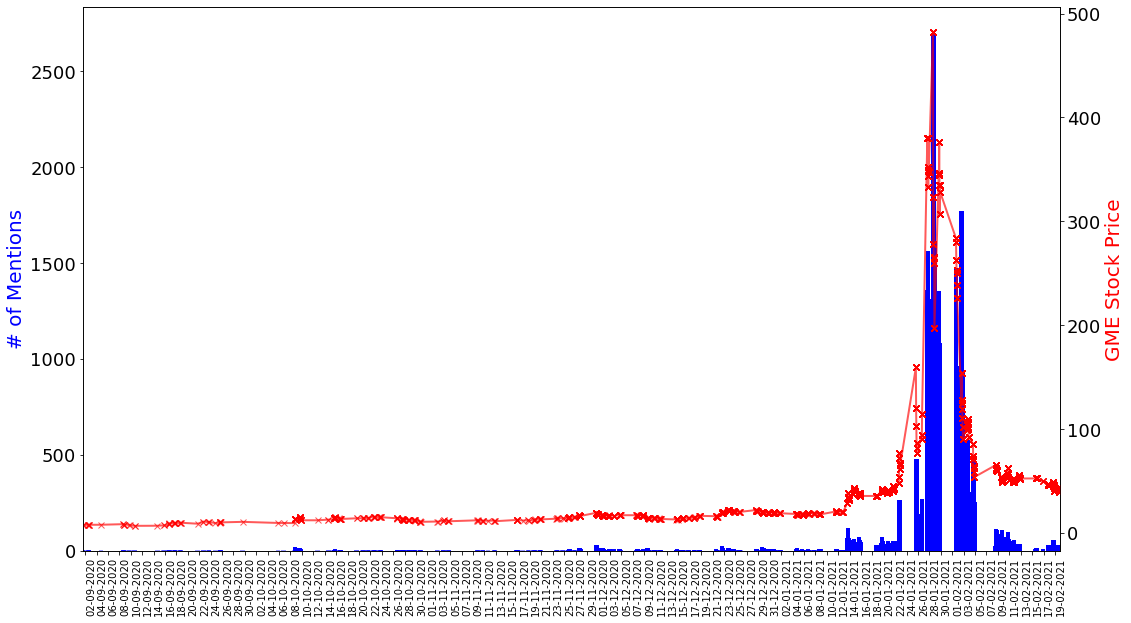

In [6]:
plot(
    df_hourly,
    date_col="date_hour",
    count_col="GME_counts",
    stock_price_col="high",
    stock_name="GME",
    save_as="plots/correlation_gme_stock_price.png",
)

## Result 2: Sentiment Analysis

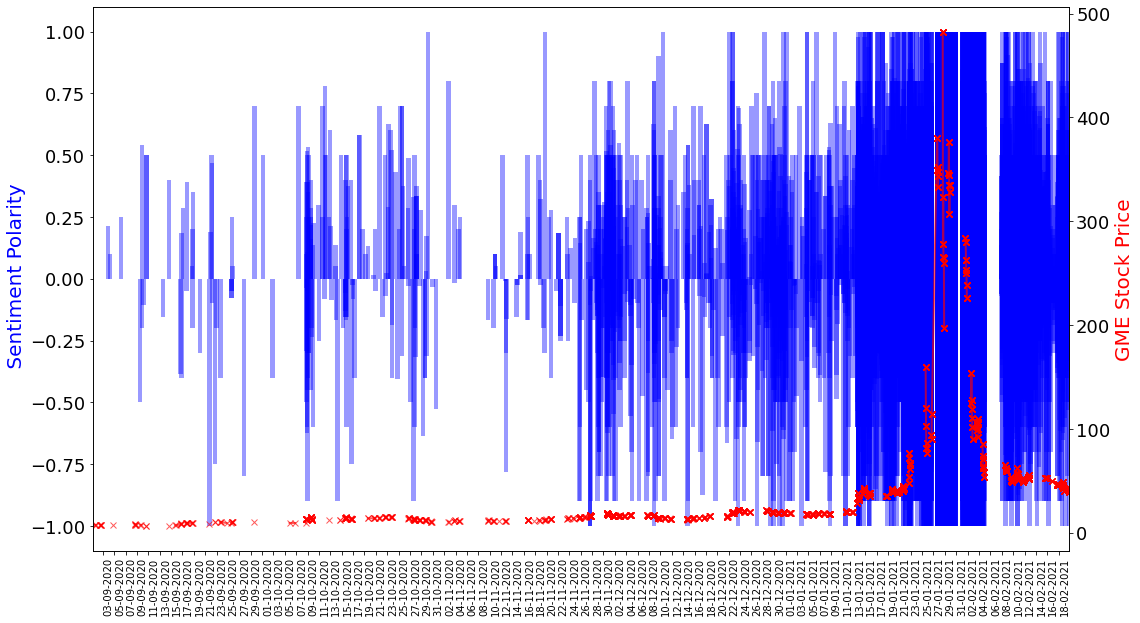

In [7]:
plot(
    sentiment_hourly,
    date_col="date_hour",
    count_col="sentiment_polarity",
    y_label=" Sentiment Polarity",
    stock_price_col="high",
    stock_name="GME",
    save_as="plots/sentiment_polarity_with_stock_price.png",
)

## OLS Regression: Which variables can explain changes in stock price?

In [8]:
y = df_hourly["high"]
X = df_hourly[
    [
        "GME_counts",
        "upvote_ratio",
        "num_comments",
        "num_crossposts",
        "total_awards_received",
        "no_follow",
        "subreddit_subscribers",
        "stickied",
    ]
]
X = sm.add_constant(X)

In [9]:
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   high   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     6518.
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:51:04   Log-Likelihood:            -3.4894e+05
No. Observations:               58918   AIC:                         6.979e+05
Df Residuals:                   58909   BIC:                         6.980e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   163.28